In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import autograd

In [2]:
from collections import OrderedDict

layers = OrderedDict([
    ('conv1', nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5)),
    ('relu1', nn.ReLU()),
    ('conv2', nn.Conv2d(in_channels=20, out_channels=64, kernel_size=5)),
    ('relu2', nn.ReLU()),
])
model = nn.Sequential(layers)

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(in_features=16*5*5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()        

In [4]:
x = torch.eye(2, 5)
x

tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.]])

In [5]:
y = torch.rand([5, 3])
y

tensor([[0.6486, 0.1897, 0.9120],
        [0.5561, 0.6617, 0.1128],
        [0.5101, 0.3438, 0.1461],
        [0.2352, 0.1730, 0.9140],
        [0.2693, 0.5586, 0.1468]])

In [6]:
a = y.t() @ y

In [7]:
b = torch.inverse(y.t() @ y)

In [8]:
a.t() @ b

tensor([[ 1.0000e+00,  2.5484e-07,  2.3961e-07],
        [-3.6939e-07,  1.0000e+00,  1.3018e-07],
        [ 3.0221e-07,  3.3111e-07,  1.0000e+00]])

In [9]:
a = a.numpy()
a

array([[1.1178709 , 0.85745907, 0.9831997 ],
       [0.85745907, 0.9339296 , 0.5380394 ],
       [0.9831997 , 0.5380394 , 1.7227641 ]], dtype=float32)

In [10]:
b.type()

'torch.FloatTensor'

In [11]:
a = torch.ones(1, requires_grad=True)
a.requires_grad

True

In [12]:
b = torch.ones(1, requires_grad=True)
b.requires_grad

True

In [13]:
total = a + b
total.requires_grad

True

In [14]:
total.backward()

In [15]:
a, a.grad

(tensor([1.], requires_grad=True), tensor([1.]))

In [16]:
with torch.no_grad():
    total = a + b

In [17]:
total.requires_grad

False

In [18]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

### LinReg with Pytorch, Gradient Descent and GPU 

In [19]:
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt

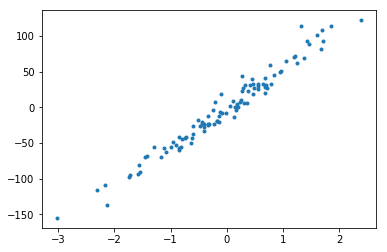

In [20]:
n_features = 1
n_samples = 100

X, y = make_regression(
    n_samples=n_samples,
    n_features=n_features,
    noise=10
)
fix, ax = plt.subplots()
ax.plot(X, y, ".")

In [21]:
X.dtype, len(X)

(dtype('float64'), 100)

In [22]:
y.dtype, len(y)

(dtype('float64'), 100)

In [23]:
X = torch.from_numpy(X).float()
y = torch.from_numpy(y.reshape(n_samples, n_features)).float()

In [24]:
from torch import nn
from torch import optim

In [25]:
class LinReg(nn.Module):
    def __init__(self, input_dim):
        super(LinReg, self).__init__()
        self.beta = nn.Linear(in_features=input_dim, out_features=1)
    
    def forward(self, X):
        return self.beta(X)

In [26]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = LinReg(n_features).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

X, y = X.to(device), y.to(device)

In [27]:
# training mode - should have splitted the data into training dataset and evaluation dataset

model.train()
optimizer.zero_grad()

y_ = model(X)
loss = criterion(y_, y)

loss.backward(loss)
optimizer.step()


# evaluation mode- should have splitted the data into training dataset and evaluation dataset

model.eval()
with torch.no_grad():
    y_ = model(X)

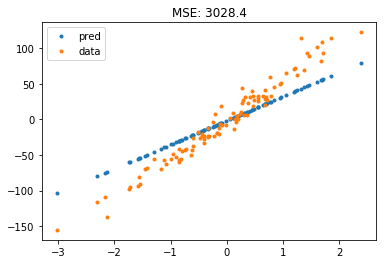

In [28]:
fig, ax = plt.subplots()
ax.plot(X.cpu().numpy(), y_.cpu().numpy(), '.', label='pred')
ax.plot(X.cpu().numpy(), y.cpu().numpy(), '.', label='data')
ax.set_title(f'MSE: {loss.item():0.1f}')
ax.legend()

### Debugging

In [29]:
from IPython.core.debugger import set_trace

In [30]:
def check_debugger(x):
    answer = 42
    set_trace()
    answer += x
    return answer

check_debugger(12)

> <ipython-input-30-c99e87515c44>(4)check_debugger()
      2     answer = 42
      3     set_trace()
----> 4     answer += x
      5     return answer
      6 

ipdb> exitr
*** NameError: name 'exitr' is not defined
ipdb> exit


BdbQuit: 

In [34]:
X = torch.rand([5, 3]).to(device)

In [36]:
class LinReg2(nn.Module):
    def __init__(self):
        super(LinReg2, self).__init__()
        self.lin = nn.Linear(in_features=3, out_features=1)
        
    def forward(self, X):
        # set_trace()
        x = self.lin(X)
        return x
    
model = LinReg2().to(device)
y_ = model(X)

assert y_.shape == (5, 1), y_.shape